In [1]:
# neural network that takes in four design variables from composites and outputs a predicted failure load

# ----------------------------------------------------
# INPUT
# [fiber type, fiber weight, dispersing agent, mixing]
# ----------------------------------------------------
# # fiber type
# ## 0 = PR
# ## 1 = OX
# ----------------------------------------------------
# # fiber weight
# ## .25 -> 1.00 in .25 increments
# ----------------------------------------------------
# # dispersing agent
# ## 0 = no
# ## 1 = yes
# ----------------------------------------------------
# # mixing
# ## 0 = SO
# ## 1 = HS
# ## 2 = HS + SO
# ----------------------------------------------------

In [2]:
# IMPORTS 
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [3]:
# Bring in data
df = pd.read_excel('Flex_Data.xlsx', usecols='B:E,K', skiprows=3)

# one-hotify the data that is not numerical
df['Fiber\nType'] = df['Fiber\nType'].map({'PR':0, 'OX':1})
df['Dispersing\nAgent'] = df['Dispersing\nAgent'].map({'No':0, 'Yes':1})
df['Mixing'] = df['Mixing'].map({'SO':0, 'HS':1, 'SO+HS':2})

# rename the failure load column
df.rename(columns={'Unnamed: 10':'Failure Load'}, inplace = True)

# create a train and test set from the data
train_df = df[df.index % 2 == 0]
train_df = train_df.sample(frac=1)
test_df = df.drop(train_df.index)

# create data set of the experimentally found Failure Load
train_labels = train_df.pop('Failure Load')
test_labels = test_df.pop('Failure Load')

# convert the pandas dataframes to numpy arrays
train_dataset = train_df.to_numpy()
train_labels = train_labels.to_numpy() / 1451.933

test_dataset = test_df.to_numpy()
test_labels = test_labels.to_numpy() /1451.933

In [4]:
# Build model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=[4,]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# optimizer chosen for fitting the data
optimizer = tf.keras.optimizers.RMSprop(.001)
# optimizer = tf.keras.optimizers.Adam()

# compile the model and print a summary of the model
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [5]:
# define the epochs and train the model
EPOCHS = 10000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split=0.1,
  verbose=0)

In [6]:
# test the model on the test data that was set aside
test_predict = model.predict(test_dataset)

predicted = []
actual = []

with open('testDataRaw/frac_50_res.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ANN prediction'])
    writer.writerow(['variables', 'actual', 'predicted'])

    for sample in range(len(test_labels)):
        
        actual.append(test_labels[sample])
        predicted.append(test_predict[sample])
        
        print(f"Test set actual: {test_labels[sample]}, Predicted: {test_predict[sample]}")
        writer.writerow([test_dataset[sample], test_labels[sample], test_predict[sample][0]])

Test set actual: 0.21219780802557692, Predicted: [0.26369047]
Test set actual: 0.477423545025838, Predicted: [0.46182555]
Test set actual: 0.565347023588554, Predicted: [0.3600595]
Test set actual: 0.406802517747031, Predicted: [0.2643736]
Test set actual: 0.25797609118327086, Predicted: [0.3490767]
Test set actual: 0.2106336862651376, Predicted: [0.26001063]
Test set actual: 0.3135681880637743, Predicted: [0.3747849]
Test set actual: 0.3467501599591717, Predicted: [0.28836852]
Test set actual: 0.20457762169466498, Predicted: [0.15117592]
Test set actual: 0.2004080078075228, Predicted: [0.3778532]
Test set actual: 0.518218815882, Predicted: [0.26555207]
Test set actual: 0.6235198180632302, Predicted: [0.44881785]
Test set actual: 0.2853988441615419, Predicted: [0.15674263]
Test set actual: 0.4666985322325479, Predicted: [0.38040268]
Test set actual: 0.5325383471551374, Predicted: [0.31258982]
Test set actual: 0.3921813196614445, Predicted: [0.4293757]
Test set actual: 0.596181779737770

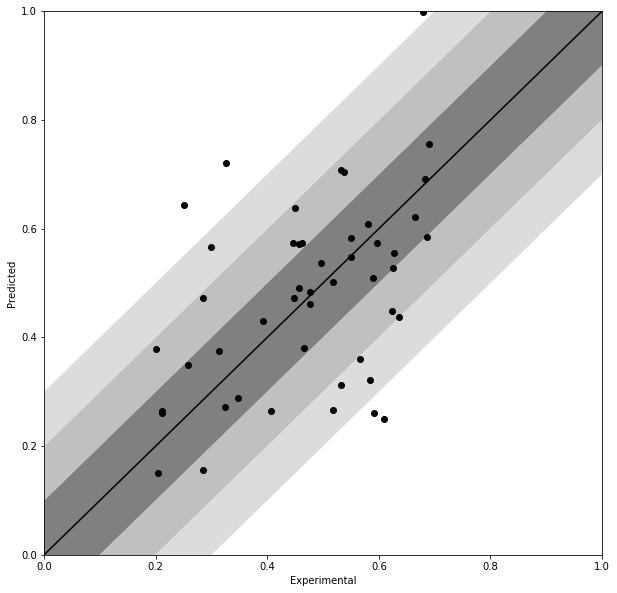

In [7]:
plt.figure(figsize=(10,10))

# 100% confidence
x = np.linspace(0,1,100)
y1 = x

plt.plot(x, y1, 'k-')

# 80% confidence interval
y2 = x + .1
y3 = x - .1

plt.fill_between(x, y1, y2,facecolor='grey')
plt.fill_between(x, y1, y3, facecolor='grey')

# 60% confidence interval
y4 = x + .2
y5 = x - .2

plt.fill_between(x, y2, y4, facecolor='silver')
plt.fill_between(x, y3, y5,facecolor='silver')

# 40% confidence interval
y6 = x + .3
y7 = x - .3

plt.fill_between(x, y4, y6, facecolor='gainsboro')
plt.fill_between(x, y5, y7, facecolor='gainsboro')

# plot results of NN
plt.plot(actual, predicted, 'ko')

plt.axis([0, 1, 0, 1])
plt.ylabel('Predicted')
plt.xlabel('Experimental')

plt.savefig('testDataPlots/frac_50_plot.png')
# plt.show()


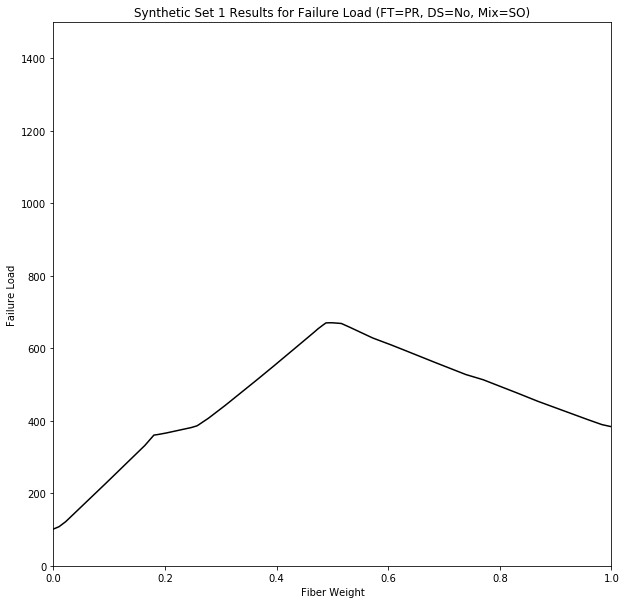

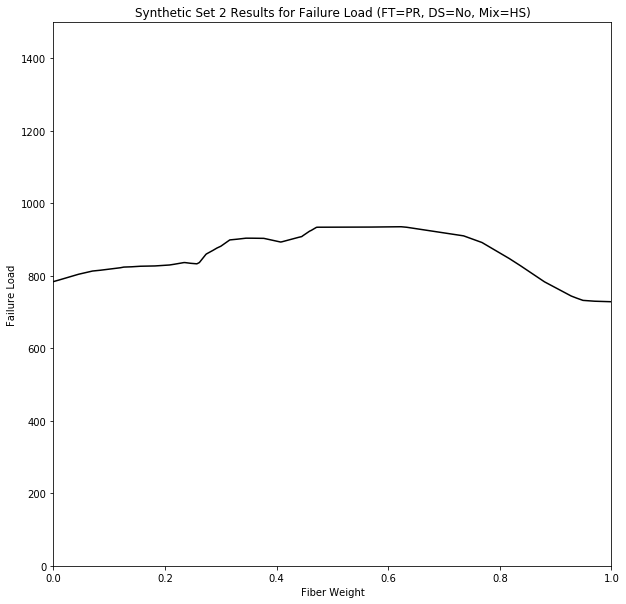

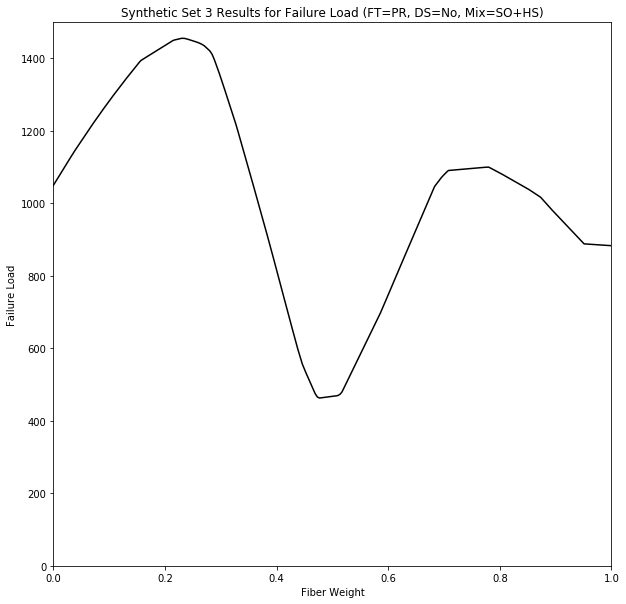

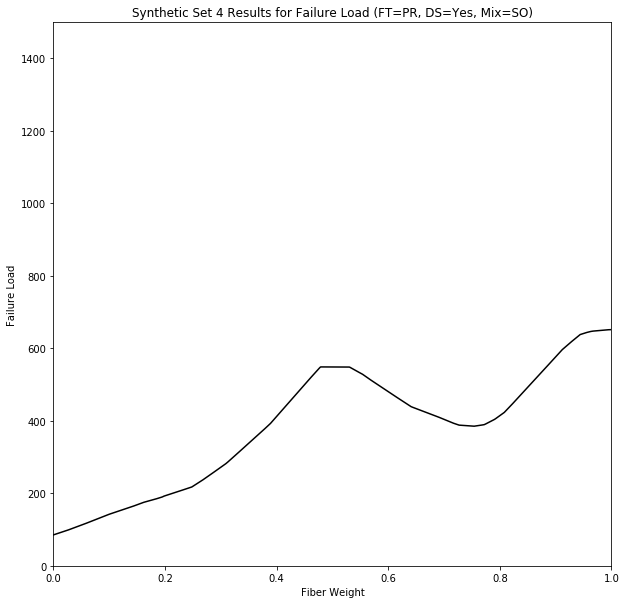

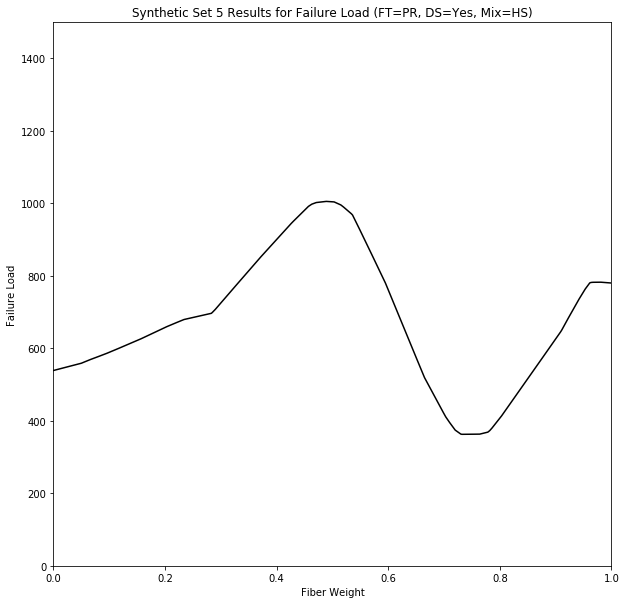

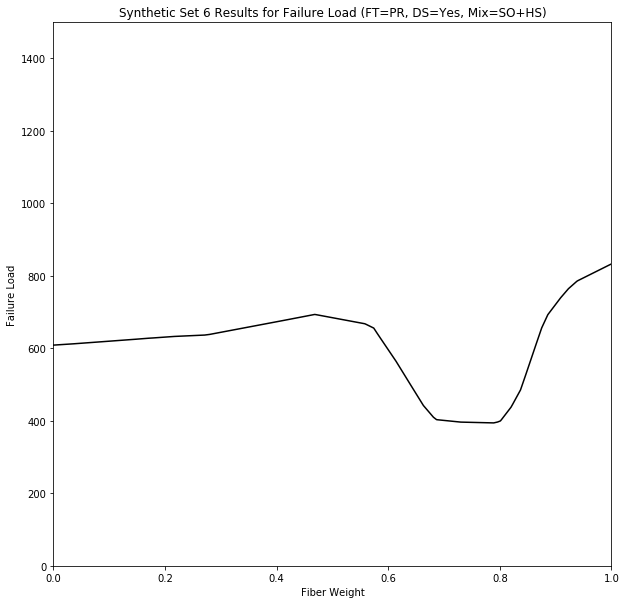

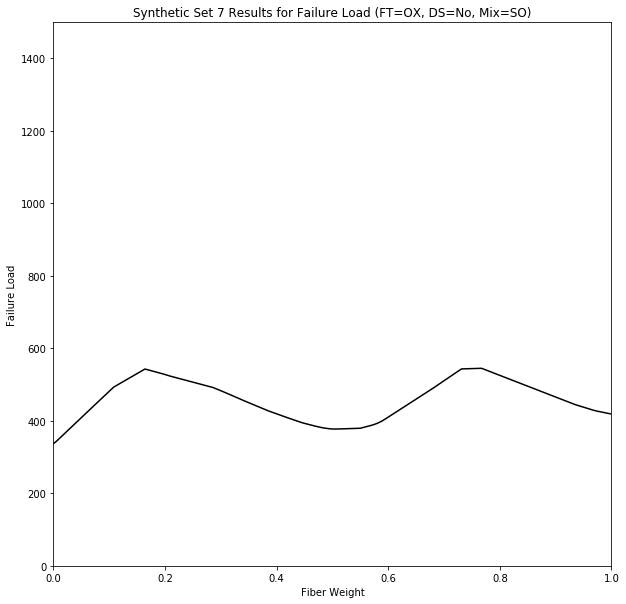

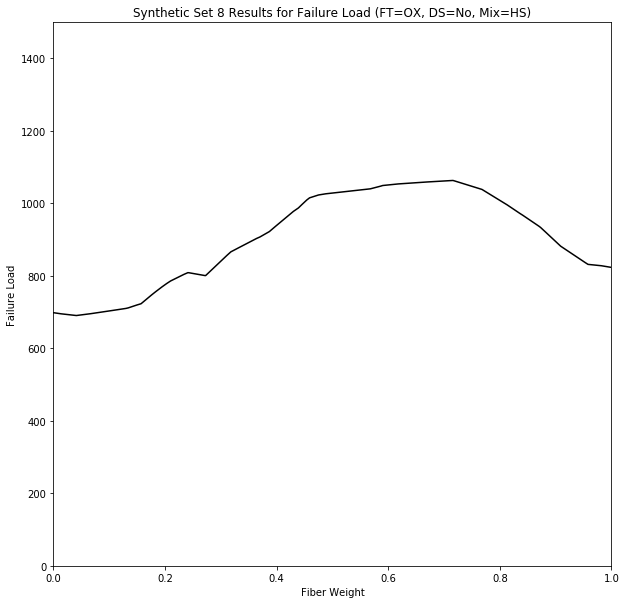

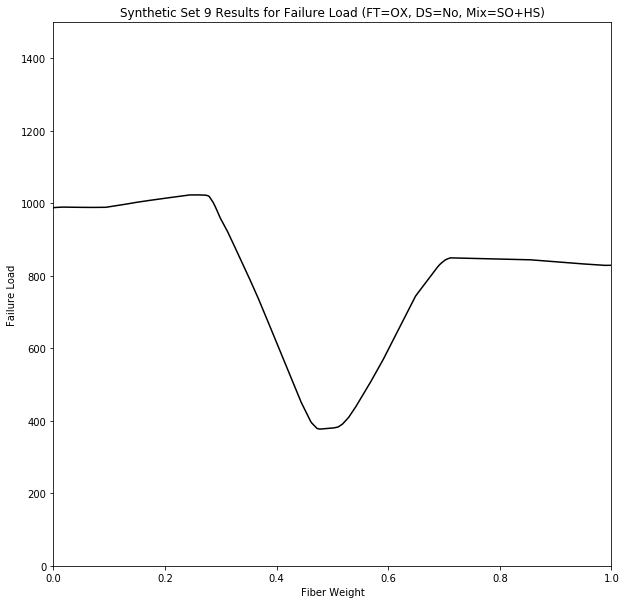

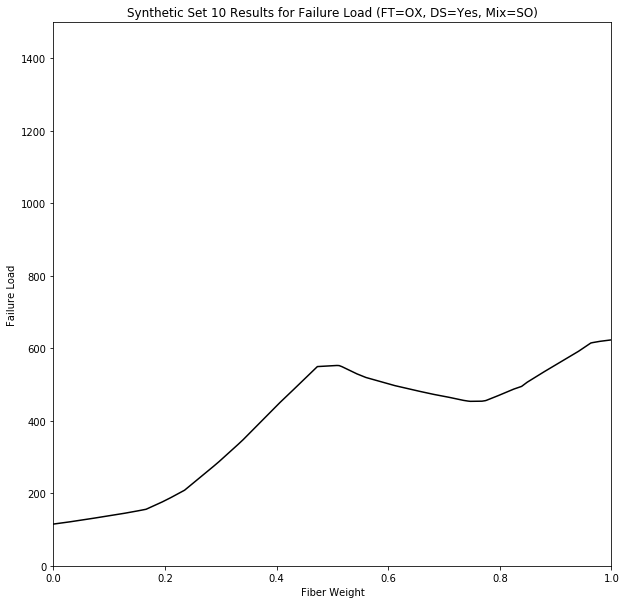

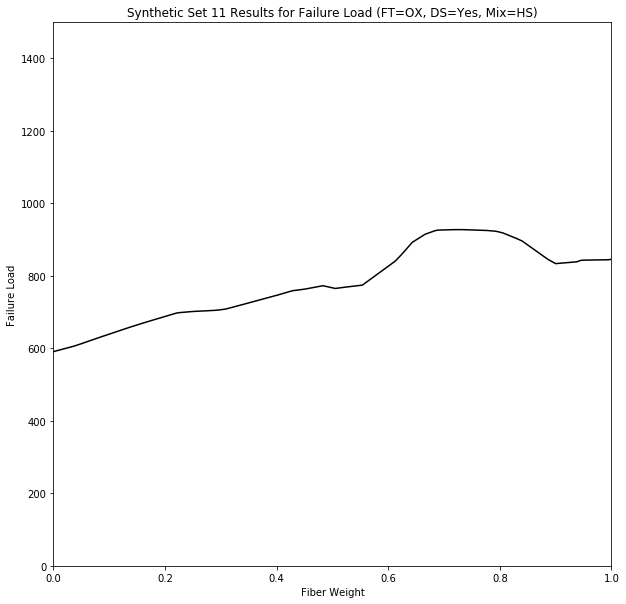

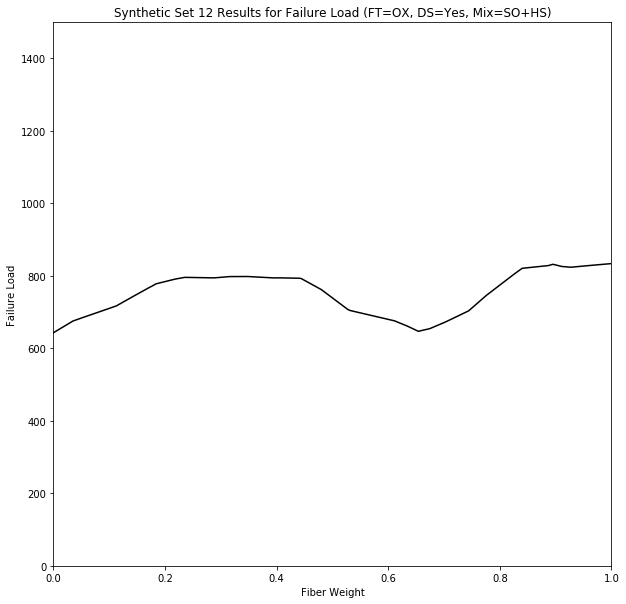

In [8]:
# THIC FOR LOOP TO GO THROUGH ALL SYNTHETIC DATA
for num in range(1, 13):
    # PREDICT SYNTHETIC DATA
    synth = pd.read_csv(f"synthData/{num}.csv")
    
    synth_arr = synth.to_numpy()
    
    synth_res = model.predict(synth_arr)
    
    # WRITE TO CSV
    with open(f'res/res_50/failureLoad/rawData/set-{num}.csv', 'w', newline='') as file:
        w = csv.writer(file)
        w.writerow(['Fiber Weight', 'Failure Load'])
        for row in range(len(synth_res)):
            w.writerow([synth_arr[row][1], synth_res[row][0] * 1451.933])
    
    # PLOT THE FAILURE LOAD
    plt.figure(figsize=(10,10))
    plt.xlim(0, 1)
    plt.ylim(0, 1500)
    
    # TITLE STUFF
    fiberType = "PR" if synth_arr[0][0] == 0 else "OX"
    dispAgent = "No" if synth_arr[0][2] == 0 else "Yes"
    mix = synth_arr[0][3]
    if mix == 0:
        mix = "SO"
    if mix == 1:
        mix = "HS"
    if mix == 2:
        mix = "SO+HS"
    plt.title(f"Synthetic Set %s Results for Failure Load (FT=%s, DS=%s, Mix=%s)" % (num, fiberType, dispAgent, mix))
    
    plt.ylabel('Failure Load')
    plt.xlabel('Fiber Weight')
    
    plt.plot(synth['Fiber Weight'], synth_res * 1451.933, 'k')
    
    plt.savefig("res/res_50/failureLoad/plots/set-%s.png" % num)


